# Neural Decomposition of Time-Series Data

We will look at recent Gashler neural network technique for the analysis and extrapolation of time-series data called Neural Decomposition (ND). ND outperforms popular time-series forecasting techniques including LSTM, echo state networks, ARIMA and SARIMA.

---

*Artificial Intelligence Group Meetup \#4, 2018-01-24*

*trokas @ Exacaster*

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
from keras.models import Input, Model, Sequential
from keras.layers.core import Dense
from keras.layers.merge import Concatenate
from keras.layers import LSTM, Activation
from keras import regularizers
from scipy.interpolate import interp1d
from fbprophet import Prophet

plt.rcParams['figure.figsize'] = [12.0, 8.0]

# Introduction

We can phrase extrapolation problem in multiple ways:

<center><img src="img/types_of_forecasting.png" alt="Types of forecasting" style="width: 50%;"/></center>

Most popular techniques:

* LSTM
* echo state networks
* ARIMA, SARIMA and friends

# Sources

Neural Decomposition (ND) technique developed by Luke B. Godfrey and Michael S. Gashler<sup>1</sup>.

Gashler et.al.<sup>2</sup> had simmilar idea in 2014 which gave promissing results, but was much slower and needed much higher computation time.

*1: Godfrey, Luke B., and Michael S. Gashler. "Neural decomposition of time-series data for effective generalization." arXiv preprint arXiv:1705.09137, 2017, [arXiv](https://arxiv.org/abs/1705.09137)*

*2: Gashler, Michael S., and Stephen C. Ashmore. "Training deep fourier neural networks to fit time-series data." International Conference on Intelligent Computing. Springer, Cham, 2014, [arXiv](https://arxiv.org/abs/1405.2262)*

# Motivation

<center><img src="img/ND_comparisson.png" alt="Motivation" style="width: 70%;"/></center>

# Ok, so what is ND?

<center><img src="img/ND_structure_formula.png" alt="ND Formula" style="width: 35%;"/>
<img src="img/ND_structure.png" alt="ND Structure" style="width: 35%;"/></center>


# Play time: our implementation

Ours ND neural network architecture is a **combination of four different activation functions** (*sin*, *softplus*, *softmax* and *linear*).

<center><img src="img/ND_model.png" alt="Neural Decomposition model structure for sequences of length $100$" style="width: 50%;"/></center>

We use Adam optimizer. Initial weights are based on Fourier transform:
1. set *sin* layer kernel to $2 \pi \left\lfloor n/2 \right\rfloor$
2. set *sin* layer bias to $\pi/2 \left(1 + k \pmod{2}\right)$
3. set *linear* layer kernel to ones with some small noise
4. set all other weights to small values around zero

# Implementation of ND in keras

In [5]:
def create_model(n, units=10, noise=0.001):
    """
    Constructs neural decomposition model and returns it
    """
    data = Input(shape=(1,), name='time')
    # sin will not work on TensorFlow backend, use Theano instead
    sinusoid = Dense(n, activation=np.sin, name='sin')(data)
    linear = Dense(units, activation='linear', name='linear')(data)
    softplus = Dense(units, activation='softplus', name='softplus')(data)
    sigmoid = Dense(units, activation='sigmoid', name='sigmoid')(data)
    combined = Concatenate(name='combined')([sinusoid, linear, softplus, sigmoid])
    out = Dense(1, kernel_regularizer=regularizers.l1(0.01), name='output')(combined)

    model = Model(inputs=[data], outputs=[out])    
    model.compile(loss="mse", optimizer="adam")

    model.weights[0].set_value((2*np.pi*np.floor(np.arange(n)/2))[np.newaxis,:].astype('float32'))
    model.weights[1].set_value((np.pi/2+np.arange(n)%2*np.pi/2).astype('float32'))
    model.weights[2].set_value((np.ones(shape=(1,units)) + np.random.normal(size=(1,units))*noise).astype('float32'))
    model.weights[3].set_value((np.random.normal(size=(units))*noise).astype('float32'))
    model.weights[4].set_value((np.random.normal(size=(1,units))*noise).astype('float32'))
    model.weights[5].set_value((np.random.normal(size=(units))*noise).astype('float32'))
    model.weights[6].set_value((np.random.normal(size=(1,units))*noise).astype('float32'))
    model.weights[7].set_value((np.random.normal(size=(units))*noise).astype('float32'))
    model.weights[8].set_value((np.random.normal(size=(n+3*units,1))*noise).astype('float32'))
    model.weights[9].set_value((np.random.normal(size=(1))*noise).astype('float32'))

    return model

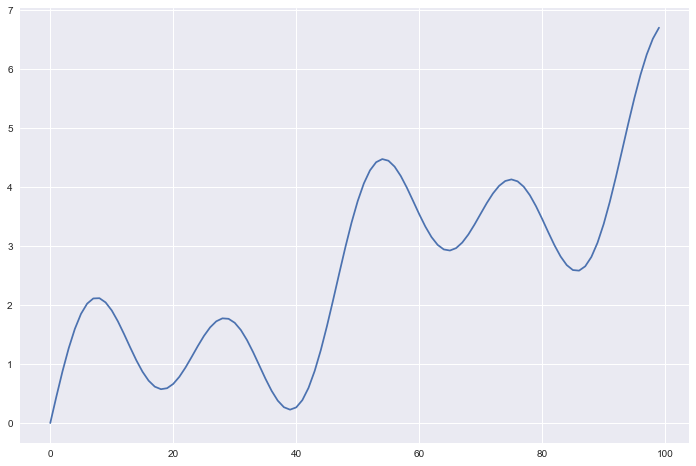

In [6]:
t = np.linspace(0, 1, 100)
X = np.sin(4.25*np.pi*t) + np.sin(8.5*np.pi*t) + 5*t
plt.plot(X)

Wall time: 15.8 s


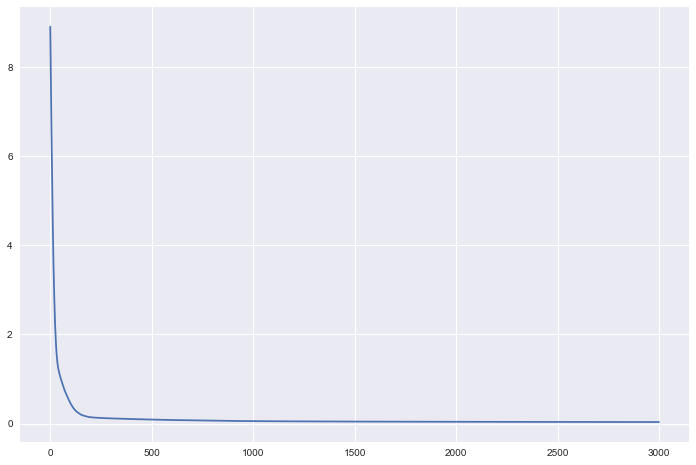

In [7]:
%%time
model = create_model(len(X))
hist = model.fit(t, X, epochs=3000, verbose=0)
plt.plot(hist.history['loss'])

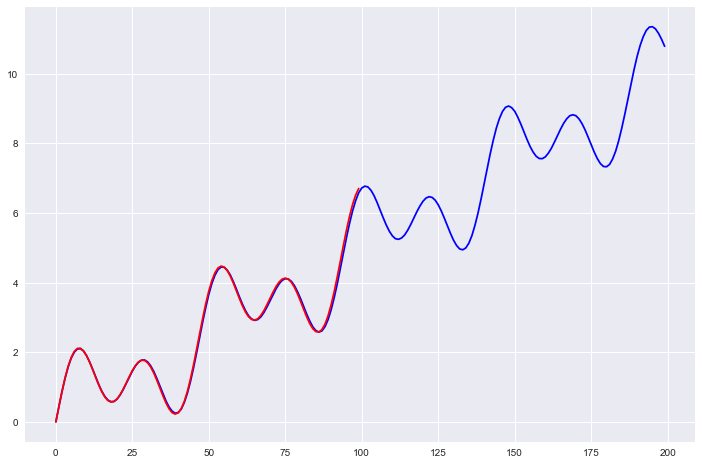

In [8]:
prediction = model.predict(np.linspace(0, 2, 200)).flatten()

plt.plot(prediction, color='blue')
plt.plot(X, color='red')

What if we add some noise?

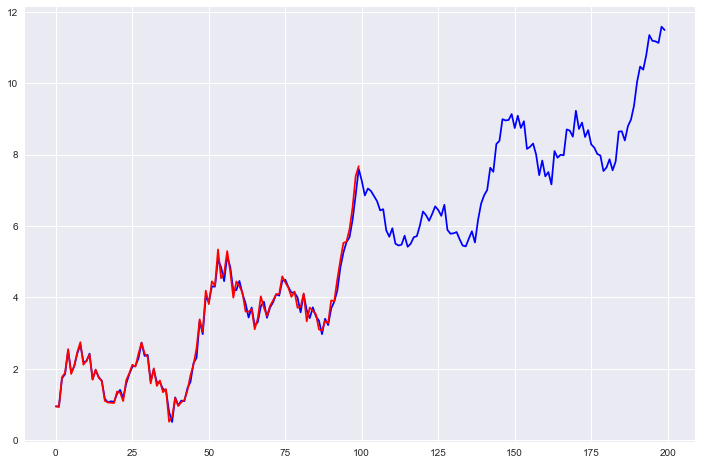

In [9]:
t = np.linspace(0, 1, 100)
X = np.sin(4.25*np.pi*t) + np.sin(8.5*np.pi*t) + 5*t + np.random.uniform(size=100)
model = create_model(len(X))
hist = model.fit(t, X, epochs=3000, verbose=0)
prediction = model.predict(np.linspace(0, 2, 200)).flatten()
plt.plot(prediction, color='blue')
plt.plot(X, color='red')

# Improvements: interpolation

We found that short sequences can be handled much better if we apply interpolation before training ND.

In [10]:
def extrapolate(l):
    """
    Extrapolates sequence by appending half original length predictions
    """
    n = l.shape[0]

    # if sequence contains a single element, then continue with it
    if len(set(l)) == 1:
        return np.concatenate([l, l[0] * np.ones(int(n / 2))])

    minimum = l.min()
    maximum = l.max()
    # as suggested in paper we apply scaling to [0, 10] range
    l_scaled = (l - minimum) / (maximum - minimum) * 10
    # we have found that interpolation can make significant difference!
    extension = 200 // n + 1     # perform interpolation if necessary
    x = np.linspace(0, 1, n)     # result will be in original scale
    x_extended = np.linspace(0, 1, n * extension)
    model = create_model(n * extension)
    f = interp1d(x, l_scaled)
    hist = model.fit(x_extended, f(x_extended), epochs=3000, verbose=0)
    # prediction is made for next n/2 steps
    p = model.predict(np.concatenate([x, 1 + np.arange(1, int(n / 2) + 1) * x[1]])).flatten()
    p_scaled = p * (maximum - minimum) / 10 + minimum
    return p_scaled

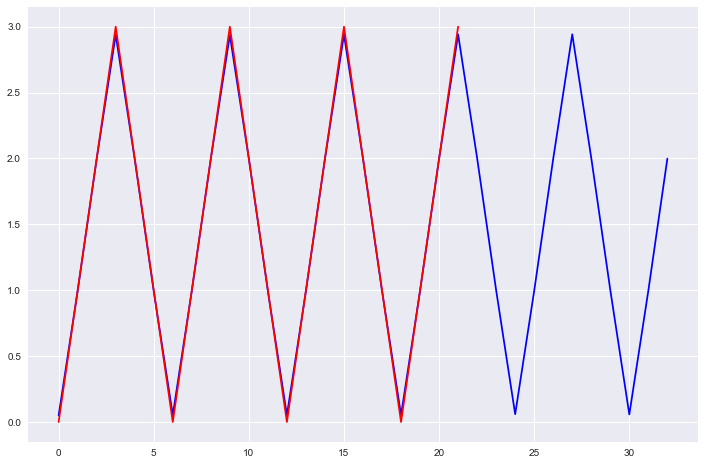

In [11]:
X = np.array([0,1,2,3,2,1,0,1,2,3,2,1,0,1,2,3,2,1,0,1,2,3])
plt.plot(extrapolate(X), color='blue')
plt.plot(X, color='red')

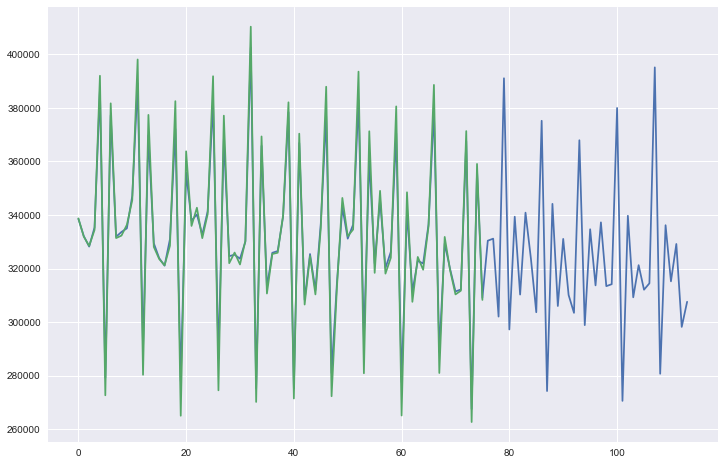

In [12]:
X = np.array([338724, 331931, 328455, 334421, 391999, 272637, 381702, 331363, 332303, 336323, 345523, 398088, 280292, 377388, 328077, 323557, 321173, 328521, 382514, 265001, 363779, 335905, 342708, 331343, 340291, 391829, 274492, 377101, 321980, 325956, 321507, 330396, 410345, 270156, 369335, 310654, 325416, 325903, 339857, 382085, 271440, 370368, 306532, 324730, 310319, 335090, 387908, 272291, 313158, 346371, 332055, 334575, 393551, 280868, 371271, 318385, 349026, 318088, 324017, 380557, 265087, 348474, 307544, 324318, 319541, 335786, 388593, 280969, 331809, 319325, 310324, 311712, 371335, 262645, 359064, 308262])
ND_forecast = extrapolate(X)
plt.plot(ND_forecast)
plt.plot(X)

# ND vs Prophet

Can we "outperform" Facebook predictions?

[Prophet](https://facebook.github.io/prophet/)<sup>1</sup> is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

*1: Taylor, Sean J., and Benjamin Letham. Forecasting at Scale. No. e3190v1. PeerJ Preprints, 2017.*

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


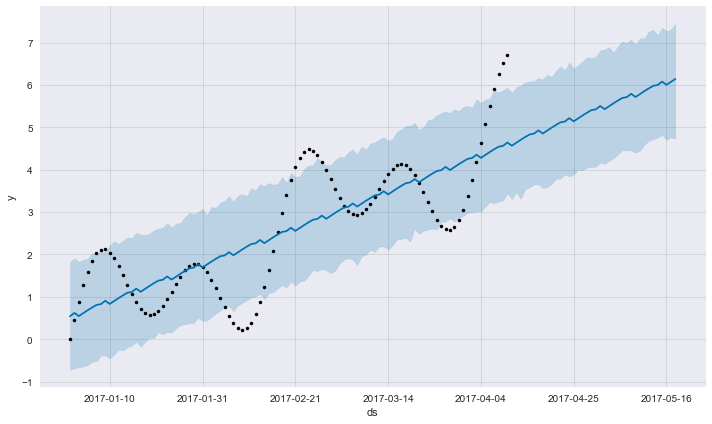

In [13]:
m = Prophet()
df = pd.DataFrame()
df["ds"] = pd.date_range('2017-01-01', '2017-04-10')
t = np.linspace(0, 1, 100)
df["y"] = np.sin(4.25*np.pi*t) + np.sin(8.5*np.pi*t) + 5*t
m.fit(df)
future = m.make_future_dataframe(periods=38)
forecast = m.predict(future)
m.plot(forecast)
plt.show()

Hm, looks like sophisticated method can fail with simple sequence. What about our real life example?

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


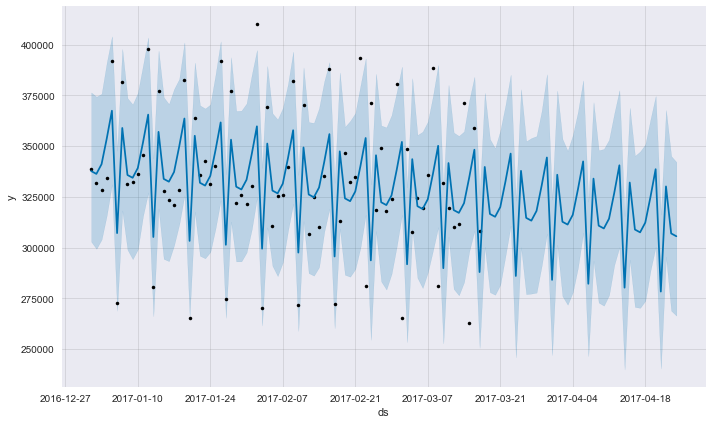

In [14]:
m = Prophet()
df = pd.DataFrame()
df["ds"] = pd.date_range('2017-01-01', '2017-03-17')
df["y"] = X
m.fit(df)
future = m.make_future_dataframe(periods=38)
forecast = m.predict(future)
m.plot(forecast)
plt.show()

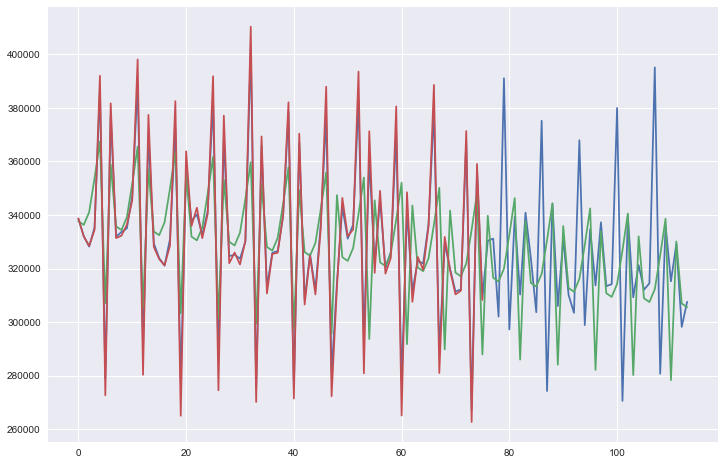

In [15]:
plt.plot(ND_forecast)
plt.plot(forecast.yhat)
plt.plot(X)

**Note:** we do not claim that ND is supperior, but it might suit some of the use cases better.

# Neural Decomposition implemented in PyTorch

Since some of you might be using PyTorch instead of keras, you might find this usefull.

In [ ]:
class ND(nn.Module):
    def __init__(self, n, units=10, noise=0.001):
        super(ND, self).__init__()
        self.wave = nn.Linear(1, n)
        self.unit_linear = nn.Linear(1, units)
        self.unit_softplus = nn.Linear(1, units)
        self.unit_sigmoid = nn.Linear(1, units)
        self.fc = nn.Linear(n + 3*units, 1)
        # Initialize weights
        params = dict(self.named_parameters())
        params['wave.weight'].data = torch.from_numpy((2*np.pi*np.floor(np.arange(n)/2))[:,np.newaxis]).float()
        params['wave.bias'].data = torch.from_numpy(np.pi/2+np.arange(n)%2*np.pi/2).float()
        params['unit_linear.weight'].data = torch.from_numpy(np.ones(shape=(units,1)) + np.random.normal(size=(units,1))*noise).float()
        params['unit_linear.bias'].data = torch.from_numpy(np.random.normal(size=(units))*noise).float()
        params['unit_softplus.weight'].data = torch.from_numpy(np.random.normal(size=(units,1))*noise).float()
        params['unit_softplus.bias'].data = torch.from_numpy(np.random.normal(size=(units))*noise).float()
        params['unit_sigmoid.weight'].data = torch.from_numpy(np.random.normal(size=(units,1))*noise).float()
        params['unit_sigmoid.bias'].data = torch.from_numpy(np.random.normal(size=(units))*noise).float()
        params['fc.weight'].data = torch.from_numpy(np.random.normal(size=(1,n+3*units))*noise).float()
        params['fc.bias'].data = torch.from_numpy(np.random.normal(size=(1))*noise).float()

    def forward(self, x):
        sinusoid = torch.sin(self.wave(x))
        linear = self.unit_linear(x)
        softplus = nn.Softplus()(self.unit_softplus(x))
        sigmoid = nn.Sigmoid()(self.unit_sigmoid(x))
        combined = torch.cat([sinusoid, linear, softplus, sigmoid], dim=1)
        out = self.fc(combined)
        return out

# x = np.linspace(0, 1.5, 150)
# x = np.sin(4.25*np.pi*x)+np.sin(8.5*np.pi*x)+5*x
x = np.linspace(0,1,100)[:, np.newaxis]
X = Variable(torch.from_numpy(x).float())
y = np.sin(np.linspace(0,20,100))[:, np.newaxis]
Y = Variable(torch.from_numpy(y).float())

nd = ND(x.shape[0])
print(nd)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nd.parameters())  

# Train the Model
for epoch in range(2000):
    # Forward + Backward + Optimize
    optimizer.zero_grad()  # zero the gradient buffer
    outputs = nd.forward(X)
    loss = criterion(outputs, Y)

    # Add L1 to loss
    loss += 0.01*torch.sum(torch.abs(dict(nd.named_parameters())['fc.weight']))

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print ('Epoch {0}, Loss: {1:.4f}'.format(epoch, loss.data[0]))

# Closing remarks, tips and ideas

* You can easily extract global trend.
* Fixing frequencies might be relevant for some applications.
* What about using only frequencies which are relevant for your application?
* What about using it as a component of more sophisticated architecture?
* Maybe there is a better way to initialize weights?
* Can this be used instead of fft in some applications?

We will share *keras* and *Pytorch* implementation with this notebook, so you can play with ND. 